# Importation des librairies necessaires au travail

In [1]:
import re
import os
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve,auc, roc_auc_score

# Lecture des fichiers de données à classifier

In [2]:
listofspam=[]#list ou on va mettre tous les spam
listofham=[]#list ou on va mettre tous les non spam
spam=os.listdir("C:/Users/Vaio/Downloads/DATA/spam")
for i in spam :
        try :
            f=open(os.path.join("C:/Users/Vaio/Downloads/DATA/spam/",i),'r', encoding='utf-8')
            content=f.read()
        except UnicodeDecodeError:
            open(os.path.join("C:/Users/Vaio/Downloads/DATA/spam/", i), "r", encoding="latin-1")
            content = f.read()
            open(os.path.join("C:/Users/Vaio/Downloads/DATA/spam/", i), "w", encoding="utf-8")
            f.write(content)
        listofspam.append(content)
ham=os.listdir("C:/Users/Vaio/Downloads/DATA/ham")
for i in ham:
    try :
        f=open(os.path.join("C:/Users/Vaio/Downloads/DATA/ham/",i),'r', encoding='utf-8')
        content=f.read()
    except UnicodeDecodeError:
        open(os.path.join("C:/Users/Vaio/Downloads/DATA/ham/", i), "r", encoding="latin-1")
        content = f.read()
        open(os.path.join("C:/Users/Vaio/Downloads/DATA/ham/", i), "w", encoding="utf-8")
        f.write(content)
    listofham.append(content)
#print(listofspam[0])

# préparation des données
Nettoyage d’emails :

Minuscule : l'intégralité de l'e-mail devra être convertie en minuscules.

Suppression de balises HTML : Toutes les balises HTML devront être supprimées des e-mails. De
nombreux e-mails sont souvent accompagnés d'un formatage HTML ; toutes les Balises HTML devront
être supprimées, de sorte que seul à garder uniquement le contenu de l’email.

Normalisation des URL : Toutes les URL devront être remplacées par le texte « httpaddr ».

Normalisation des adresses e-mail : toutes les adresses e-mail devront être remplacées avec le texte
"emailaddr".

Normalisation des nombres : Tous les nombres devront être remplacés par le texte "nombre".

Normalisation des dollars : Tous les signes dollar ($)devront être remplacés par le texte "dollar".

Radicalisation de mots : Les mots devront être réduits à leur forme radicale. Par exemple, "discount",
"discounts", "discounted" et "discounting" devront être tous remplacé par " discount", et "include",
"includes", "included", et "ncluded" devront être tous remplacés par « includ ».

Suppression des non-mots : les non-mots et la ponctuation devront être supprimés. Tous les espaces
blancs (onglets, nouvelles lignes, espaces) devront être remplacés par un seul espace.

In [3]:
def datapreparation(l):
    for i in range(0,len(l)):
        l[i]=l[i].lower()#minuscule
        l[i] = re.sub('<[^<>]+>', ' ', l[i])#suppression des balises html
        l[i]= re.sub('(http|https)://[^\s]*', 'httpaddr', l[i])#normalisation des url
        l[i]= re.sub('[^\s]+@[^\s]+', 'emailaddr', l[i]) #normalisation des adresses mail
        l[i]= re.sub(r'\d+', 'number', l[i])#normalisation des nombres
        l[i]= re.sub('[$]+', 'dollar', l[i])#normalisation des dollars
        l[i] = l[i].translate(str.maketrans('', '', punctuation)) #suppression de la ponctuation
        l[i]= re.sub("\n"," ", l[i])#suppression des sauts de lignes
        #radicalisation et suppression des espaces et des non mots
        l[i]=l[i].split()
        l2=""
        stemmer = SnowballStemmer("english")
        for j in range(0,len(l[i])):
            if l[i][j].isalpha():
                l[i][j] = stemmer.stem(l[i][j])
            l2=l2+l[i][j]+" "
        l[i]=l2
    #print(listofspam[0])#pour voir un exemple apres nettoyage
datapreparation(listofspam)#preparation des spam
datapreparation(listofham)#preparation des non spam
#print(listofspam[0])

# Construction du vocabulaire
Après le prétraitement des e-mails, une liste de mots sera pour chaque e-mail. L'étape suivante consiste
à choisir les mots que nous aimerions utiliser dans notre classificateur et que nous voudrions laisser de
côté. Pour ce projet, il est possible de choisir uniquement les mots les plus fréquents (la liste de
vocabulaire). Puisque les mots qui se produisent rarement dans l'ensemble de formation ne sont que
dans quelques e-mails, ils peuvent provoquer un sur-apprentissage.

La liste complète du vocabulaire devra être sauvegardée dans un fichier, exemple vocab.txt.
Dans cette liste de vocabulaire seulement les mots qui apparaissent au moins K fois dans le corpus de
spam devront être gardés. K devra être choisi empiriquement. En pratique, une liste de vocabulaire
avec environ 10 000 à 50 000 mots sont souvent utilisés.

Une fois ayant obtenu la liste de vocabulaire, il sera possible de mapper chaque mot dans l’email
prétraité à son index dans une liste d'index de mots (qui contient l'index du mot dans la liste de
vocabulaire).

Ceci est fait en cherchant le mot dans le vocabulaire liste vocabList et trouver si le mot existe. Si oui, il
devra être ajouté dans la variable index des mots. Si le mot n'existe pas, et n'est donc pas dans le
vocabulaire, le mot devra être ignoré.

In [4]:
from collections import Counter
def createvocab(l):
    fichier = open("vocab.txt", "w" ,encoding="utf-8")
    cpt = Counter()
    for i in range(len(l)):
        for word in l[i].split(" "):
            cpt[word] += 1 #compter le nombre d occurence de chaque mot
    vocab = sorted(cpt, key=cpt.get, reverse=True)
    vocab=vocab[:10000]#vocab sera une list des 10000 mots qui se repetent le plus
    for i in vocab :#on remplit vocab.txt par les 10000 mots qui se repetent le plus
        fichier.writelines(i)
        fichier.writelines("\n")
    fichier.close()   
    vocabdict = {}   
    lenvocab=len(vocab)
    # mapper chaque mot dans l’email prétraité à son index 
    for i,word in enumerate(vocab):
        vocabdict[word]=i
    #print(vocabdict)
    return [lenvocab,vocabdict] 
[vocab_size,vocabdict]=createvocab(listofspam)

# Création du DataFrame contenant les emails spams et non spams avec label =1 si l'email est un spam sinon 0

In [5]:
df=pd.DataFrame(listofspam, columns = ['email'])
df["label"]=0
#print(df)

In [6]:
df2=pd.DataFrame(listofham, columns = ['email'])
df2["label"]=1
#print(df2)

In [7]:
data=pd.concat([df, df2])
#print(data)

In [8]:
email = pd.DataFrame(data['email'])
label = pd.DataFrame(data['label'])
print(email)
#print(label)

                                                  email
0     from emailaddr tue aug number numbernumbernumb...
1     from emailaddr mon jun number numbernumbernumb...
2     from emailaddr mon jun number numbernumbernumb...
3     from emailaddr mon jun number numbernumbernumb...
4     from emailaddr tue aug number numbernumbernumb...
...                                                 ...
1646  from emailaddr tue nov number numbernumbernumb...
1647  from emailaddr tue nov number numbernumbernumb...
1648  from emailaddr tue nov number numbernumbernumb...
1649  from emailaddr wed dec number numbernumbernumb...
1650  mv numbernumbercnumberdnumberenumberbbenumbere...

[3048 rows x 1 columns]


# Extraction de caractéristiques

L'extraction de fonctionnalités devra convertir chaque e-mail en un vecteur dans 𝑅 . Pour ce projet, 𝑛
nous utiliserons n = # mots de vocabulaire liste.

Nous avons choisi la représentation des caractéristiques par comptage :

In [50]:
#generation des caracteristiques pour chaque mail ca sera un vecteur de taille  du vocabulaire 
def emailtovector(email):#cette fonction nous peremettera de generer le vecteur de caracteristiaue d'un email donnée
    vecteur_mots = np.zeros(vocab_size)# initialisation du vecteur de caracteristique
    for mot in email.split(" "):#pour chaque mot du mail si le mot existe dans le vocabulaire incrementer son nombre d'apparition
        if vocabdict.get(mot) is None:#si le mot n'existe pas dans le vocabulaire on va l'ignorer
            continue
        else:
            vecteur_mots[vocabdict.get(mot)] += 1
    return np.array(vecteur_mots)

#pour tous les email :
vecteurs_mots = np.zeros((len(email), vocab_size), dtype=np.int_)
for i, (_, text_) in enumerate(email.iterrows()):
    vecteurs_mots[i] = emailtovector(text_[0])

vecteurs_mots.shape 

(3048, 10000)

# Classification


Dans cette etape nous avons utiliser les classifieurs suivant :

    1-regression logistique
    
    2-Machine à vecteurs de support(SVM)
    
    3-Naive Bayes
    
    4-Les arbres de decision
    
    5-Méthode des k plus proches voisins
    
    6-Random Forest
    
    7- Reseaux de neuronnes
   

In [10]:
futures=vecteurs_mots

In [11]:
X_train, X_test, y_train, y_test = train_test_split(futures, data['label'], test_size=0.33, random_state=100)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2042, 10000)
(1006, 10000)
(2042,)
(1006,)


In [14]:
rl = LogisticRegression(solver='liblinear', penalty='l1')
svm = SVC(kernel='linear', probability=True)
nb = MultinomialNB()
dt = DecisionTreeClassifier(min_samples_split=7, random_state=111)
n=neighbours()
kpp = KNeighborsClassifier(n)
rf = RandomForestClassifier(n_estimators=40, random_state=111)
rn=MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10000, 2), random_state=111)

In [15]:
clfs = {'SVM' : svm,'k plus proches voisins' : kpp, 'Naive Bayes': nb, 'Les arbres de decision': dt, 'regression logistique': rl, 'Random Forest': rf,"Reseaux de neuronnes":rn}


In [13]:
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [12]:
#choisir meilleur parametre pour knn on va faire une boucle qui a chaque fois nous teste l accuracy et nous retourn le meilleur 
#hyperparametre
def neighbours():
    bestneighbour=0
    prec=0
    for i in range(1,20):
        model = KNeighborsClassifier(n_neighbors=i) 
        train(model, X_train, y_train)
        pred = predict(model, X_test)
        p=accuracy_score(y_test , pred)*100
        if p>prec:
            prec=p
            bestneighbour=i
        #print("precision pour nombre de voisins",i,"voisins=",p)
    return bestneighbour

# Entrainement et Mesures de performances

Confusion Matrix:


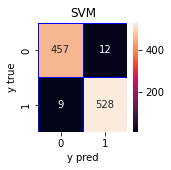

ROC CURVE:


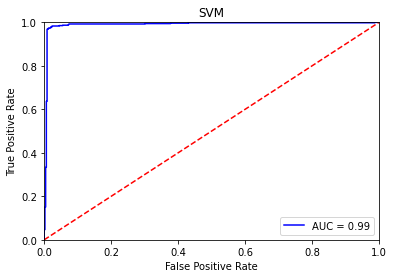

Confusion Matrix:


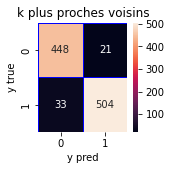

ROC CURVE:


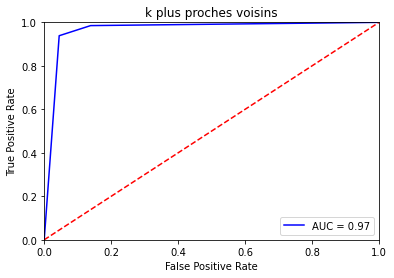

Confusion Matrix:


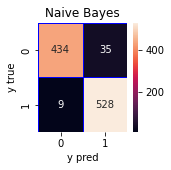

ROC CURVE:


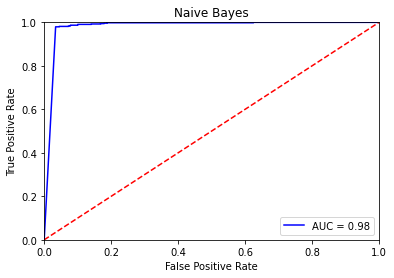

Confusion Matrix:


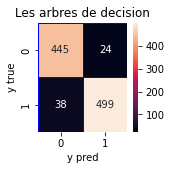

ROC CURVE:


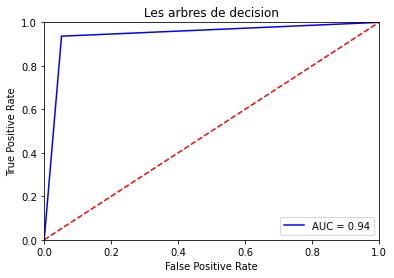

Confusion Matrix:


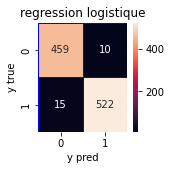

ROC CURVE:


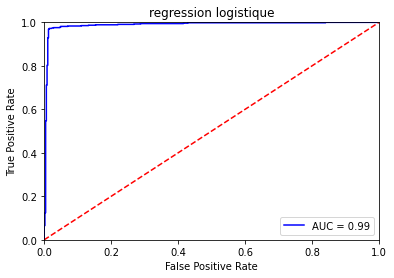

Confusion Matrix:


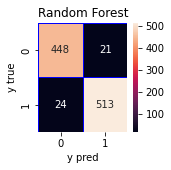

ROC CURVE:


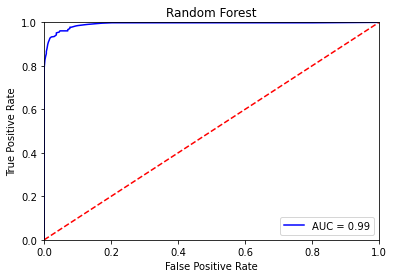

In [ ]:
precision = []
recall = []
fpr= []
tnr= []
def trainandmetrics():
    for k,v in clfs.items():
        train(v, X_train, y_train)
        pred = predict(v, X_test)
        probs = v.predict_proba(X_test)
        preds = probs[:,1]
        fp, tn, threshold = roc_curve(y_test, preds)
        roc_auc = auc(fp, tn)
        precision.append((k, [accuracy_score(y_test , pred)*100]))
        recall.append((k, [recall_score(y_test , pred)*100]))
        print("Confusion Matrix:")
        cm = confusion_matrix(y_test,pred)
        f, ax = plt.subplots(figsize =(2,2))
        sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="blue",fmt = ".0f",ax=ax)
        plt.title(k)
        plt.xlabel("y pred")
        plt.ylabel("y true")
        plt.show()
        print("ROC CURVE:")
        plt.title(k)
        plt.plot(fp, tn, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        fp=fp.mean()
        fpr.append((k,fp*100))
        tn=tn.mean()
        tnr.append((k,tn*100))
    print("Precision pour chaque classifieur")
    for i in precision:
        print(i)
    print("\n")
    print("Rappel pour chaque classifieur")
    for i in recall:
        print(i)
    print("\n")
    print("fpr pour chaque classifieur")
    for i in fpr:
        print(i)
    print("\n")
    print("tnr pour chaque classifieur")
    for i in tnr:
        print(i)
trainandmetrics()

En comparant les classifieurs utilisee on obtient les meilleurs precisions avec les SVM , Regression logistique
et reseaux de neuronnes 97% de precision 